<a href="https://colab.research.google.com/github/koalanoir/Prediction_elections_presidentiels/blob/main/Etude_tx_d_abstention_election_presidentielle_france.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from sklearn.cluster import KMeans
import torch.optim as optim
import io
# Librairie graphique plotly
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


import plotly.tools as tls
import plotly.figure_factory as ff

import plotly.io as pio
pio.renderers.default = "colab"

In [53]:

def extraireDfFromExcel(chemin_fichier):
# Lire les noms de toutes les feuilles de calcul
  xl = pd.ExcelFile(chemin_fichier)
  feuilles = xl.sheet_names

# Créer un dictionnaire pour stocker les DataFrames de chaque feuille
  dataframes = {}

# Lire chaque feuille de calcul et stocker les données dans le dictionnaire
  for feuille in feuilles:
      df = pd.read_excel(chemin_fichier, sheet_name=feuille)
      dataframes[feuille] = df
  return dataframes

In [123]:
# Récupération des data set
set_abs_premier_tour = {'Années': [1995, 2002,2007,2012,2017],
        'Abstention': [21.23, 28.39, 16.23,20.51, 22.22]}
df = pd.DataFrame(set_abs_premier_tour)
df_RSA=pd.read_csv("/content/drive/MyDrive/dataset/rsa-par-departement-et-region_1.csv")
df_2022=pd.read_excel("/content/drive/MyDrive/dataset/2022_reg.xlsx")
df_chomage_dep=pd.read_excel("/content/drive/MyDrive/dataset/chomage_depart_.xlsx")
df_2022_com=pd.read_excel("/content/drive/MyDrive/dataset/departement_2022.xlsx")
df_2022_dep=pd.read_excel("/content/drive/MyDrive/dataset/resultats-par-niveau-dpt-t1-france-entiere.xlsx")

In [124]:
pop_fr=extraireDfFromExcel("/content/drive/MyDrive/dataset/population.xlsx")

In [126]:
dep=pop_fr['Départements']
dep=dep.drop(dep[dep['Code département'].isin(['2A','2B','971','972','973','974'])].index)


Normalisation


In [57]:
df_2022_dep=df_2022_dep.drop(df_2022_dep[df_2022_dep['Code du département'].isin(['2A','2B','ZA','ZB','ZC','ZD','ZM','ZN', 'ZP', 'ZS','ZX','ZW','ZZ'])].index)

In [127]:
donnees_44 = df_2022_dep.loc[df_2022_dep['Code du département'].isin(['44', '49', '85','53','72'])]
donnees_outre_mer = df_2022_dep.loc[df_2022_dep['Code du département'].isin(['ZA','ZB','ZC','ZD','ZM','ZN','ZP','ZS','ZW','ZX','ZY','ZZ'])]
donnees_ile_france = df_2022_dep.loc[df_2022_dep['Code du département'].isin(['91', '92', '93','75','78','77','94','95'])]
donnees_ile_de_france_commune=df_2022_com.loc[df_2022_com['Code du département'].isin(['91', '92', '93','75','78','77','94','95'])]
donnees_chomage=df_chomage_dep.loc[df_chomage_dep['Code departements'].isin(['F', 'P', 'M',])]
donnees_chomage=df_chomage_dep.drop(df_chomage_dep[df_chomage_dep['Code departements'].isin(['2A','2B','971','972','973','F', 'P', 'M'])].index)

In [128]:
donnees_chomage=df_chomage_dep.drop(df_chomage_dep[df_chomage_dep['Code departements'].isin(['2A','2B','971','972','973','974','F', 'P', 'M'])].index)
donnees_chomage

,Code departements,Departements,Ensemble,Hommes,Femmes,15-24 ans,25-49 ans,50 ans ou plus
0,01,Ain,5.5,5.3,5.6,13.2,5.0,3.9
1,02,Aisne,10.5,10.5,10.4,27.9,8.9,7.1
2,03,Allier,7.7,7.9,7.4,19.0,6.7,5.7
3,04,Alpes-de-Haute-Provence,8.2,8.3,8.2,21.2,7.9,5.5
4,05,Hautes-Alpes,6.9,7.1,6.7,17.0,6.8,4.5
...,...,...,...,...,...,...,...,...
91,91,Essonne,6.4,6.4,6.3,15.0,5.8,4.2
92,92,Hauts-de-Seine,5.9,6.1,5.7,11.5,5.4,5.2
93,93,Seine-Saint-Denis,10.2,10.2,10.2,19.2,9.2,8.7
94,94,Val-de-Marne,7.1,7.4,6.9,14.5,6.5,5.7


In [138]:
df = pd.DataFrame()

#df['Nom département']=df_2022_dep['Libellé du département']
#df['Code département']=df_2022_dep['Code du département']

dep=pop_fr['Départements']
df['Population municipale']=dep['Population municipale']

df['%Chomage 15-24 ans']=donnees_chomage['15-24 ans']
df['%Chomage 25-49 ans']=donnees_chomage['25-49 ans']
df['%Chomage 50 ans ou plus']=donnees_chomage['50 ans ou plus']
df['%Chomage Ensemble']=donnees_chomage['Ensemble']
df['%Chomage Femmes']=donnees_chomage['Femmes']
df['%Chomage Hommes']=donnees_chomage['Hommes']

df['% Abstention']=df_2022_dep['% Abs/Ins']
df_2022_dep['Inscrits']

df['% Voix/Ins Nouveau Parti anticapitaliste'] = df_2022_dep['Unnamed: 81']
df['% Voix/Ins Debout la France'] = df_2022_dep['Unnamed: 87']
df['% Voix/Ins Les Républicains'] = df_2022_dep['Unnamed: 75']
df['% Voix/Ins Europe Écologie Les Verts'] = df_2022_dep['Unnamed: 69']
df['% Voix/Ins Parti socialiste'] = df_2022_dep['Unnamed: 63']
df['% Voix/Ins La France insoumise'] = df_2022_dep['Unnamed: 57']
df['% Voix/Ins Reconquête'] = df_2022_dep['Unnamed: 51']
df['% Voix/Ins Rassemblement national'] = df_2022_dep['Unnamed: 45']
df['% Voix/Ins Résistons'] = df_2022_dep['Unnamed: 39']
df['% Voix/Ins La République en marche'] = df_2022_dep['Unnamed: 33']
df['% Voix/Ins Parti communiste français'] = df_2022_dep['Unnamed: 27']
df['% Voix/Ins Lutte ouvrière'] = df_2022_dep['% Voix/Ins']

df['% Voix/exp Nouveau Parti anticapitaliste'] = df_2022_dep['Unnamed: 82']
df['% Voix/exp Debout la France'] = df_2022_dep['Unnamed: 88']
df['% Voix/exp Les Républicains'] = df_2022_dep['Unnamed: 76']
df['% Voix/exp Europe Écologie Les Verts'] = df_2022_dep['Unnamed: 70']
df['% Voix/exp Parti socialiste'] = df_2022_dep['Unnamed: 64']
df['% Voix/exp La France insoumise'] = df_2022_dep['Unnamed: 58']
df['% Voix/exp Reconquête'] = df_2022_dep['Unnamed: 52']
df['% Voix/exp Rassemblement national'] = df_2022_dep['Unnamed: 46']
df['% Voix/exp Résistons'] = df_2022_dep['Unnamed: 40']
df['% Voix/exp La République en marche'] = df_2022_dep['Unnamed: 34']
df['% Voix/exp Parti communiste français'] = df_2022_dep['Unnamed: 28']
df['% Voix/exp Lutte ouvrière'] = df_2022_dep['% Voix/Exp']

Text(0.5, 1.0, 'Ensemble des départements de France en Métropole(Sans la corse)')

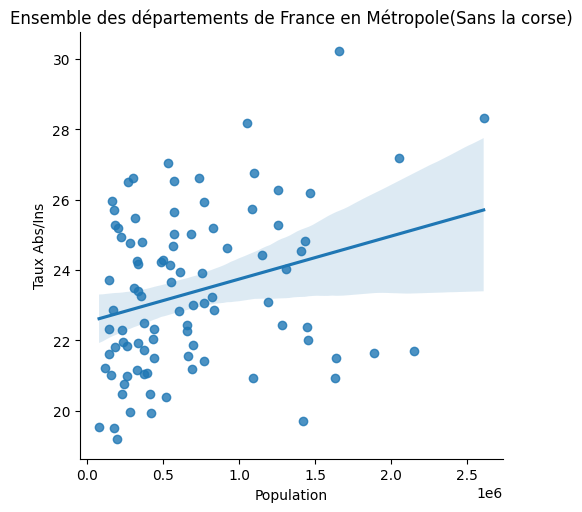

In [65]:
# Tracer le graphique de dispersion avec la droite de régression linéaire
abs_pop = {'x': df['Population municipale'],'y': df['% Abstention']}
data_fr = pd.DataFrame(abs_pop)
sns.lmplot(x="x", y='y', data=data_fr)
# Personnaliser les étiquettes d'axe et le titre
plt.xlabel("Population")
plt.ylabel("Taux Abs/Ins")
plt.title("Ensemble des départements de France en Métropole(Sans la corse)")

Text(0.5, 1.0, 'Ensemble des départements de France en Métropole(Sans la corse)')

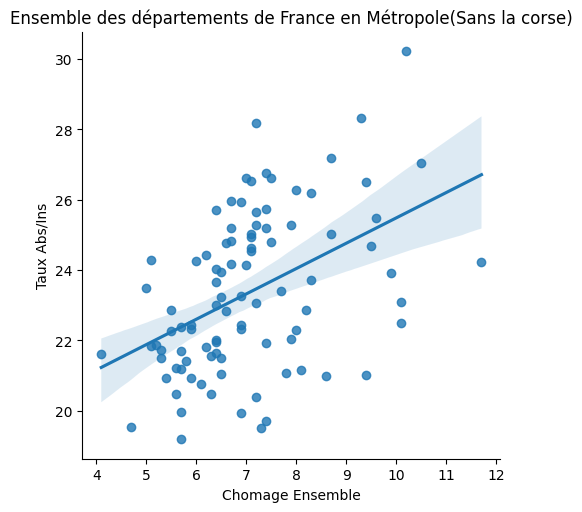

In [67]:
# Tracer le graphique de dispersion avec la droite de régression linéaire
abs_pop = {'x': df['%Chomage Ensemble'],'y': df['% Abstention']}
data_fr = pd.DataFrame(abs_pop)
sns.lmplot(x="x", y='y', data=data_fr)
# Personnaliser les étiquettes d'axe et le titre
plt.xlabel("Chomage Ensemble")
plt.ylabel("Taux Abs/Ins")
plt.title("Ensemble des départements de France en Métropole(Sans la corse)")

In [139]:

# Fonction pour déterminer la tendance en fonction des valeurs des colonnes 'gauche', 'droite' et 'centre'
def determiner_tendance(row):
    max_value = max(row['% Voix/exp Lutte ouvrière'], row['% Voix/exp Parti communiste français'], row['% Voix/exp La République en marche'],row['% Voix/exp Résistons'], row['% Voix/exp Rassemblement national'], row['% Voix/exp Reconquête'], row['% Voix/exp La France insoumise'], row['% Voix/exp Parti socialiste'],row['% Voix/exp Europe Écologie Les Verts'], row['% Voix/exp Les Républicains'], row['% Voix/exp Debout la France'],row['% Voix/exp Nouveau Parti anticapitaliste'])
    if max_value == row['% Voix/exp Lutte ouvrière'] or  max_value == row['% Voix/exp Parti communiste français'] or max_value == row['% Voix/exp Europe Écologie Les Verts']:
        return 'gauche'
    elif  max_value == row['% Voix/exp Parti socialiste'] or max_value == row['% Voix/exp La République en marche'] or max_value == row['% Voix/exp Les Républicains'] or max_value == row['% Voix/exp Nouveau Parti anticapitaliste'] or max_value == row['% Voix/exp Debout la France']:
        return 'droite'
    elif max_value == row['% Voix/exp Résistons']:
        return 'centre'
    elif max_value == row['% Voix/exp Rassemblement national']:
      return 'extreme droite'
    elif max_value == row['% Voix/exp La France insoumise'] or max_value == row['% Voix/exp Reconquête']:
      return 'extreme gauche'
    else:
        return 'inconnue'

# Appliquer la fonction à chaque ligne du DataFrame pour créer la nouvelle colonne 'tendance'
df_sne = df.loc[:93]
df_sne['tendance'] = df_sne.apply(determiner_tendance, axis=1)

In [140]:

filtre_ext_gauche = df_sne['tendance'] == 'extreme gauche'
filtre_ext_droite = df_sne['tendance'] == 'extreme droite'
filtre_centre = df_sne['tendance'] == 'centre'
filtre_gauche = df_sne['tendance'] == 'gauche'
filtre_droite = df_sne['tendance'] == 'droite'
filtre_inconnue = df_sne['tendance'] == 'inconnue'

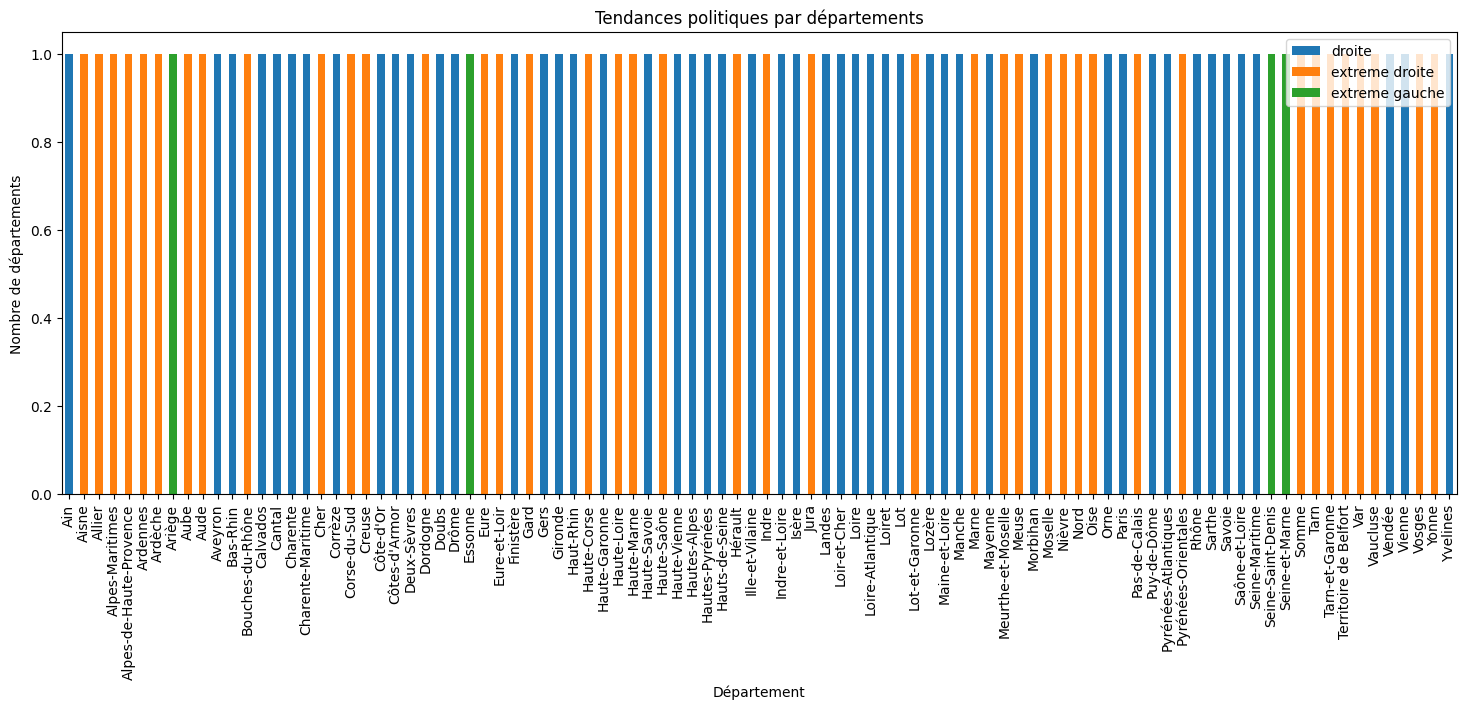

In [137]:
# Grouper les données par département et tendance, et compter le nombre de départements dans chaque tendance
df_grouped = df_sne.groupby(['Nom département', 'tendance']).size().unstack()

# Créer un graphique en barres empilées pour représenter les tendances par départements
df_grouped.plot(kind='bar', stacked=True, figsize=(18, 6))

# Ajouter des étiquettes et un titre
plt.xlabel('Département')
plt.ylabel('Nombre de départements')
plt.title('Tendances politiques par départements')

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()

In [141]:
# Exécute une transformation T_SNE sur les données
from sklearn import manifold
df_sans_nan = df.dropna()
tsne = manifold.TSNE(n_components=2, verbose=0, perplexity=10, n_iter=1000)
X_tsne = tsne.fit_transform(df_sans_nan)

In [66]:
palette = ['navy','red','maroon','orange','green','pink','grey','purple']


inconne = df_sne[filtre_inconnue]
inconnue_data = X_tsne[filtre_inconnue]

droite_data = X_tsne[filtre_droite]
gauche_data = X_tsne[filtre_gauche]
centre_data = X_tsne[filtre_centre]
ext_gauche_data = X_tsne[filtre_ext_gauche]
ext_droite_data = X_tsne[filtre_ext_droite]

inconnue_trace = go.Scatter(x=inconnue_data[:,0], y=inconnue_data[:,1], mode='markers', name='Inconnue',
                             marker=dict(color='yellow', size=5))
droite_trace = go.Scatter(x=droite_data[:,0], y=droite_data[:,1], mode='markers', name='Droite',
                          marker=dict(color='red', size=5))
gauche_trace = go.Scatter(x=gauche_data[:,0], y=gauche_data[:,1], mode='markers', name='Gauche',
                             marker=dict(color='maroon', size=5))
centre_trace = go.Scatter(x=centre_data[:,0], y=centre_data[:,1], mode='markers', name='Centre',
                           marker=dict(color='purple', size=5))
ext_droite =go.Scatter(x=ext_droite_data[:,0], y=ext_droite_data[:,1], mode='markers', name='Extreme droite',
                           marker=dict(color='green', size=5))
ext_gauche =go.Scatter(x=ext_gauche_data[:,0], y=ext_gauche_data[:,1], mode='markers', name='Extreme gauche',
                           marker=dict(color='black', size=5))

fig = go.Figure(data=[ext_gauche, centre_trace, ext_droite, gauche_trace,droite_trace,inconnue_trace])



fig.update_layout(title='Réduction de dimensions t-SNE pour les différents postes',
                  xaxis=dict(title='Dimension 1'), yaxis=dict(title='Dimension 2'))

iplot(fig)

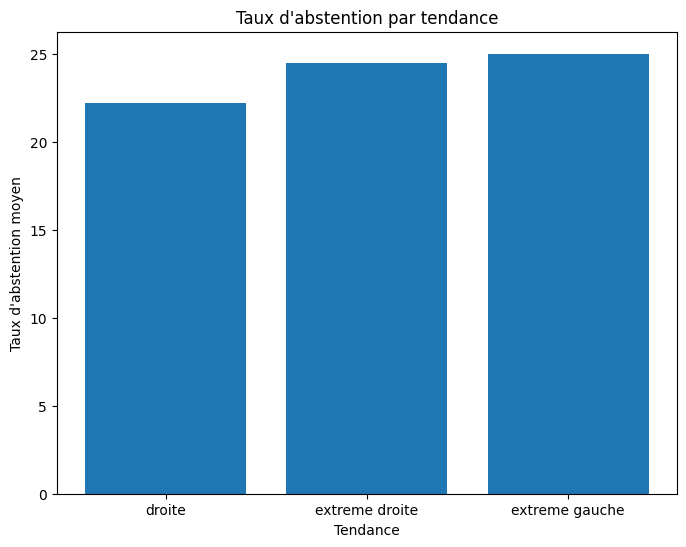

In [92]:
# Grouper les données par tendance et calculer le taux moyen d'abstention
df_grouped = df_sne.groupby('tendance')['% Abstention'].mean()

# Créer le graphique à barres
plt.figure(figsize=(8, 6))
plt.bar(df_grouped.index, df_grouped.values)
plt.xlabel('Tendance')
plt.ylabel('Taux d\'abstention moyen')
plt.title('Taux d\'abstention par tendance')
plt.show()

Apprentissage

In [159]:
from sklearn.model_selection import train_test_split

# Séparer les caractéristiques et la variable cible
X = df_sne[['Population municipale',
 '%Chomage 15-24 ans',
 '%Chomage 25-49 ans',
 '%Chomage 50 ans ou plus',
 '%Chomage Ensemble',
 '%Chomage Femmes',
 '%Chomage Hommes',
            ]]  # Caractéristiques
y = df_sne['tendance']  # Variable cible

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
# Supprimer les lignes avec des valeurs manquantes
df_sne=df_sne.dropna(axis=0)

In [160]:
from sklearn.ensemble import RandomForestClassifier

# Créer une instance du modèle Random Forest Classifier
model = RandomForestClassifier()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

RandomForestClassifier()

In [161]:
# Faire des prédictions sur les données de test
y_pred = model.predict(X_test)

In [162]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calcul des métriques d'évaluation


from sklearn.metrics import precision_score, recall_score, f1_score

# Calcul des métriques d'évaluation
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("Précision : ", precision)
print("Rappel : ", recall)
print("F1-score : ", f1)

Précision :  0.7725146198830409
Rappel :  0.7894736842105263
F1-score :  0.76656346749226


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Validation croisée

In [163]:
from sklearn.model_selection import cross_val_score, KFold
model = RandomForestClassifier(n_estimators=100, max_depth=10)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

print("Scores moyens : ", scores.mean())
print("Écart-types : ", scores.std())

Scores moyens :  0.7269005847953217
Écart-types :  0.06524072640559332


Population municipale: 0.12592039408068884
%Chomage 15-24 ans: 0.1899933696991115
%Chomage 25-49 ans: 0.10170149974897975
%Chomage 50 ans ou plus: 0.10577241773628311
%Chomage Ensemble: 0.16210291199268867
%Chomage Femmes: 0.14269151516106027
%Chomage Hommes: 0.17181789158118793


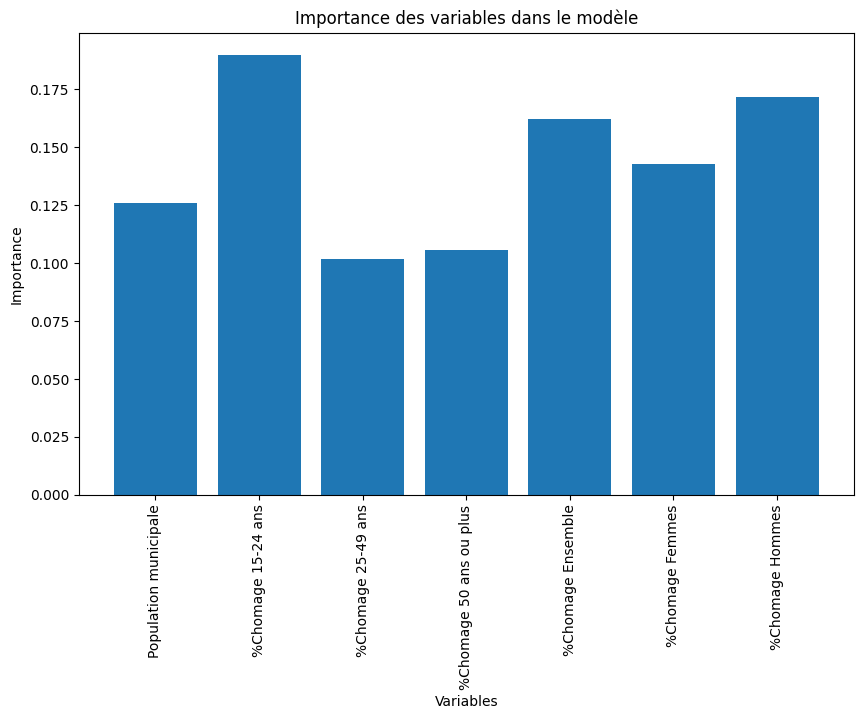

In [164]:
# Création d'une instance de RandomForestClassifier
model = RandomForestClassifier()

# Ajustement du modèle aux données d'entraînement
model.fit(X_train, y_train)

# Obtention de l'importance des variables
importances = model.feature_importances_

# Obtention des noms des variables
feature_names = X.columns  # Remplacez X par votre dataframe contenant les variables explicatives

# Affichage de l'importance des variables
for feature_name, importance in zip(feature_names, importances):
    print(f"{feature_name}: {importance}")
# Obtention des noms des variables
# Création d'un graphique à barres pour visualiser l'importance des variables
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.xticks(rotation='vertical')
plt.xlabel('Variables')
plt.ylabel('Importance')
plt.title('Importance des variables dans le modèle')
plt.show()

Data visualisation (début d'étude)


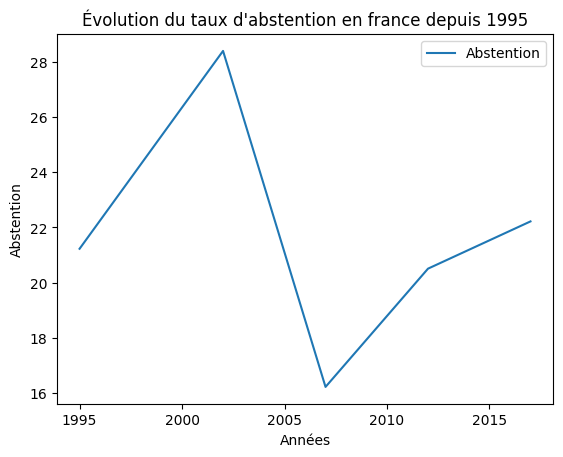

In [11]:
df.plot(x='Années', y='Abstention', kind='line')
plt.xlabel('Années')
plt.ylabel('Abstention')
plt.title("Évolution du taux d'abstention en france depuis 1995")
plt.show()

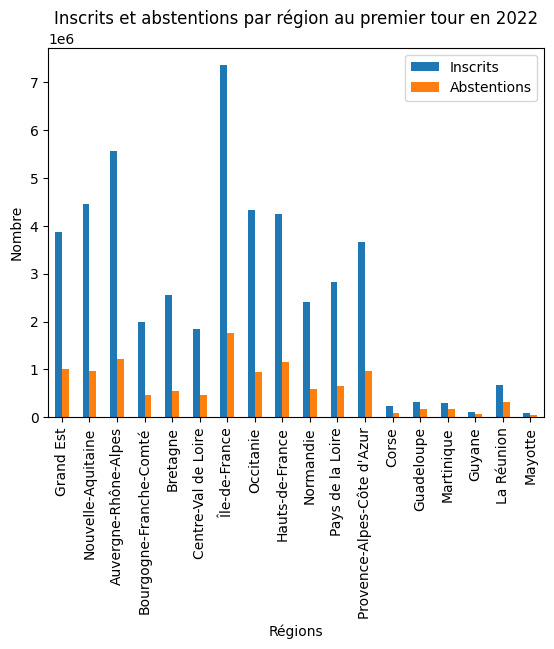

In [18]:
df_2022.plot(x='Libellé de la région', y=['Inscrits', 'Abstentions'], kind='bar')
plt.xlabel('Régions')
plt.ylabel('Nombre')
plt.title('Inscrits et abstentions par région au premier tour en 2022')
plt.legend(["Inscrits", "Abstentions"])
plt.show()

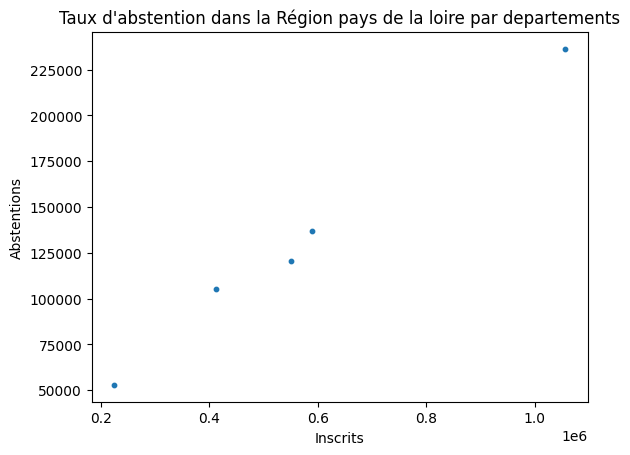

In [38]:

plt.scatter(donnees_44['Inscrits'], donnees_44['Abstentions'],s=10)
plt.xlabel('Inscrits')
plt.ylabel('Abstentions')
plt.title("Taux d'abstention dans la Région pays de la loire par departements")
plt.show()

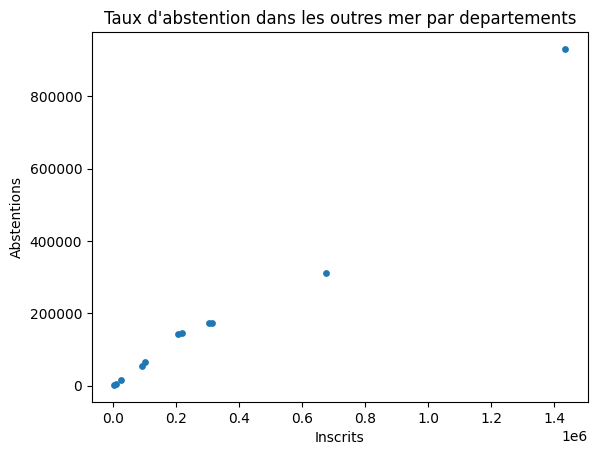

In [43]:
plt.scatter(donnees_outre_mer['Inscrits'], donnees_outre_mer['Abstentions'],s=15)
plt.xlabel('Inscrits')
plt.ylabel('Abstentions')
plt.title("Taux d'abstention dans les outres mer par departements")
plt.show()

In [24]:
pop_dep=pop_fr['Départements']
data_x1=pop_dep['Population municipale']
data_x2=donnees_chomage['25-49 ans']
data_x3=donnees_chomage['50 ans ou plus']
data_x4=donnees_chomage['Ensemble']
data_x5=donnees_chomage['Femmes']
data_x6=donnees_chomage['Hommes']
# Retirer les lignes avec les valeurs "zb", "zv" ou "zn" dans la colonne "code depart"
dff = df_2022_dep.drop(df_2022_dep[df_2022_dep['Code du département'].isin(['ZM','ZN', 'ZP', 'ZS','ZX','ZW','ZZ'])].index)
data_y=dff['% Abs/Ins']
print("size y : "+str(data_y.size)+" x : "+str(data_x1.size)+" x2 : "+str(data_x2.size))

size y : 100 x : 100 x2 : 100


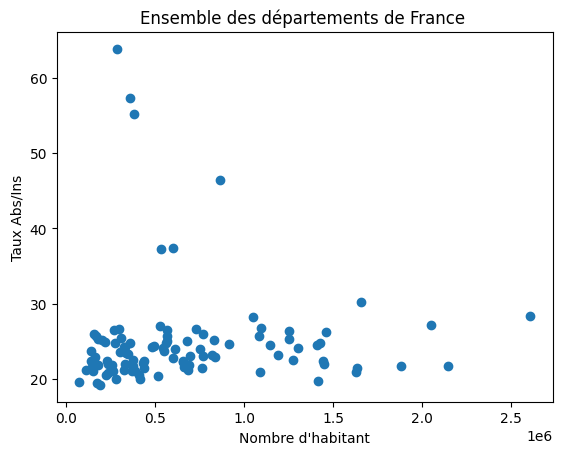

In [88]:
# Tracer le graphique de dispersion
plt.scatter(x=data_x,y=data_y)

# Personnaliser les étiquettes d'axe et le titre
plt.xlabel("Nombre d'habitant")
plt.ylabel("Taux Abs/Ins")
plt.title("Ensemble des départements de France ")

# Afficher le graphique
plt.show()

Text(0.5, 1.0, 'Ensemble des départements de France ')

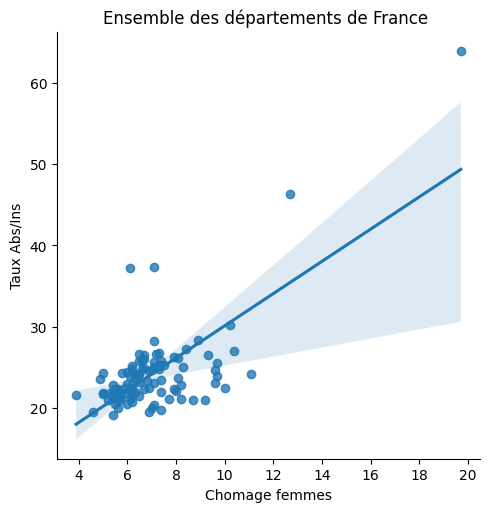

In [28]:
# Tracer le graphique de dispersion avec la droite de régression linéaire
abs_pop = {'x': data_x5,'y': data_y}
data_fr = pd.DataFrame(abs_pop)
sns.lmplot(x="x", y='y', data=data_fr)
# Personnaliser les étiquettes d'axe et le titre
plt.xlabel("Chomage femmes")
plt.ylabel("Taux Abs/Ins")
plt.title("Ensemble des départements de France ")

Text(0.5, 1.0, 'Ensemble des départements de France ')

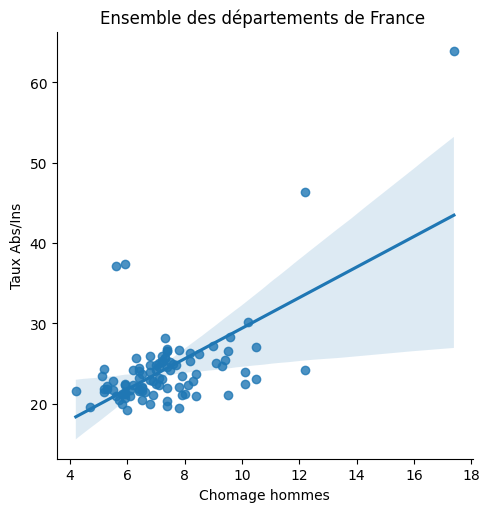

In [29]:
# Tracer le graphique de dispersion avec la droite de régression linéaire
abs_pop = {'x': data_x6,'y': data_y}
data_fr = pd.DataFrame(abs_pop)
sns.lmplot(x="x", y='y', data=data_fr)
# Personnaliser les étiquettes d'axe et le titre
plt.xlabel("Chomage hommes")
plt.ylabel("Taux Abs/Ins")
plt.title("Ensemble des départements de France ")

Text(0.5, 1.0, 'Ensemble des départements de France ')

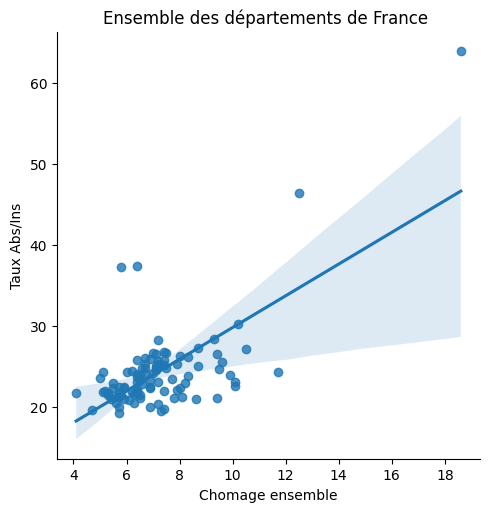

In [30]:
# Tracer le graphique de dispersion avec la droite de régression linéaire
abs_pop = {'x': data_x4,'y': data_y}
data_fr = pd.DataFrame(abs_pop)
sns.lmplot(x="x", y='y', data=data_fr)
# Personnaliser les étiquettes d'axe et le titre
plt.xlabel("Chomage ensemble")
plt.ylabel("Taux Abs/Ins")
plt.title("Ensemble des départements de France ")

Text(0.5, 1.0, 'Ensemble des départements de France ')

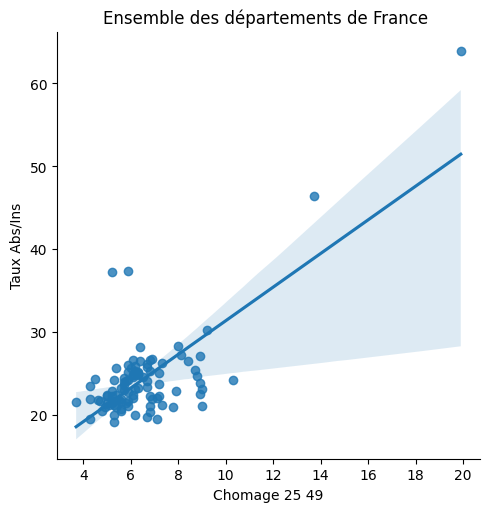

In [31]:
# Tracer le graphique de dispersion avec la droite de régression linéaire
abs_pop = {'x': data_x2,'y': data_y}
data_fr = pd.DataFrame(abs_pop)
sns.lmplot(x="x", y='y', data=data_fr)
# Personnaliser les étiquettes d'axe et le titre
plt.xlabel("Chomage 25 49")
plt.ylabel("Taux Abs/Ins")
plt.title("Ensemble des départements de France ")

Text(0.5, 1.0, 'Ensemble des départements de France ')

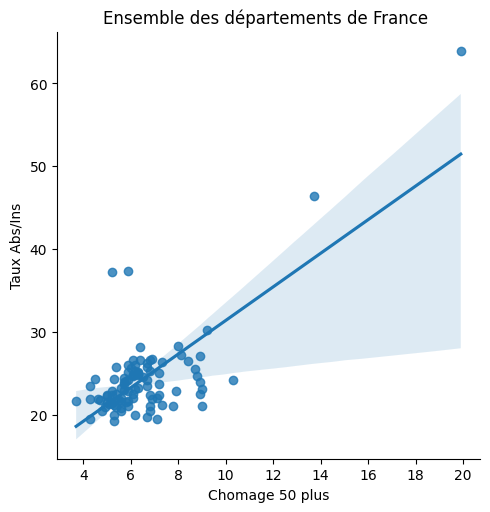

In [32]:
# Tracer le graphique de dispersion avec la droite de régression linéaire
abs_pop = {'x': data_x2,'y': data_y}
data_fr = pd.DataFrame(abs_pop)
sns.lmplot(x="x", y='y', data=data_fr)
# Personnaliser les étiquettes d'axe et le titre
plt.xlabel("Chomage 50 plus")
plt.ylabel("Taux Abs/Ins")
plt.title("Ensemble des départements de France ")

Text(0.5, 1.0, 'Ensemble des départements de France ')

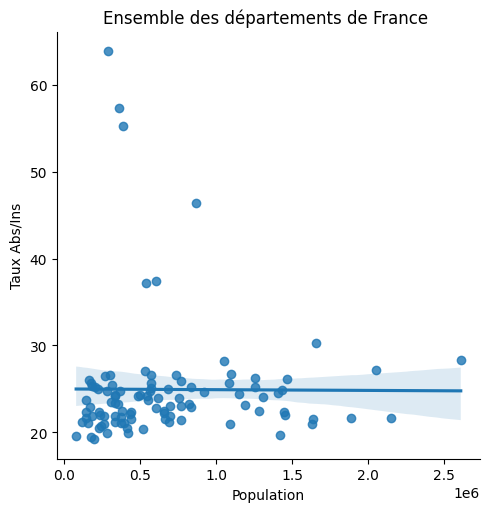

In [34]:
# Tracer le graphique de dispersion avec la droite de régression linéaire
abs_pop = {'x': data_x1,'y': data_y}
data_fr = pd.DataFrame(abs_pop)
sns.lmplot(x="x", y='y', data=data_fr)
# Personnaliser les étiquettes d'axe et le titre
plt.xlabel("Population")
plt.ylabel("Taux Abs/Ins")
plt.title("Ensemble des départements de France ")